# Hello Object Detection

A very basic introduction to using object detection models with OpenVINO™.

The [horizontal-text-detection-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/horizontal-text-detection-0001/README.md) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. It detects horizontal text in images and returns a blob of data in the shape of `[100, 5]`. Each detected text box is stored in the `[x_min, y_min, x_max, y_max, conf]` format, where the
`(x_min, y_min)` are the coordinates of the top left bounding box corner, `(x_max, y_max)` are the coordinates of the bottom right bounding box corner and `conf` is the confidence for the predicted class.



## Imports
[back to top ⬆️](#Table-of-contents:)


In [1]:
import openvino as ov
import cv2
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path   # 디렉토리 모델 불러기기

## Download model weights
[back to top ⬆️](#Table-of-contents:)


## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [2]:
#device = device_widget()
#device
core = ov.Core()
options=core.available_devices
options

['CPU', 'GPU', 'NPU']

## Load the Model


In [3]:
#core = ov.Core()

model = core.read_model(model="model/horizontal-text-detection-0001.xml")
compiled_model = core.compile_model(model=model, device_name="CPU") # 윗줄에서 지정한 model과 위에서 선택했던, CPU 를 compiled_model에넣는다.

#input_layer_ir = compiled_model.input(0)
#output_layer_ir = compiled_model.output("boxes")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output("boxes")

print(input_layer.shape)

[1,3,704,704]


## Load an Image
[back to top ⬆️](#Table-of-contents:)


In [8]:
# Download the image from the openvino_notebooks storage
# data 폴더에 이미지를 다운로드함.
#image_filename = download_file(
#    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg",
#    directory="data",
#)

# Text detection models expect an image in BGR format. intel_mb.jpg 파일을 불러와 image변수에 저장
#image = cv2.imread('data/intel_rnb.jpg')
image = cv2.imread('data/1111.jpg')
#print(image.shape)  # 이미지 크기(H,W,C) 컬러이미지의 채널은 3이다.

# 이미지 전처리
- 정해진 오픈비노 input  값으로 사용할 이미지의 크기를 조정해준다.

(704, 704, 3)
(1, 3, 704, 704)


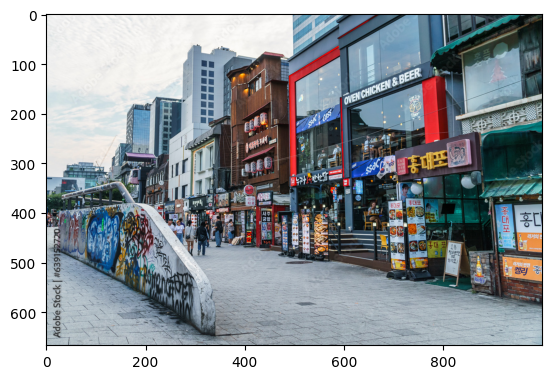

In [9]:
# input 이미지로 사용할 이미지의 크기와 차원을 확장한다.

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer.shape  #[1,3,704,704]

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H)) #704,704 크기로 이미지 사이즈 변경
print(resized_image.shape)

# Reshape to the network input shape. 차원확장
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)  # 0번지에 차원을 확장함.
print(input_image.shape)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Do Inference
[back to top ⬆️](#Table-of-contents:)


In [10]:
# Create an inference request.
boxes = compiled_model([input_image])[output_layer]
print(boxes)
# [input_image] 가 [1,3,704,704] 인데 [output_layer_ir] 인 [100,5]으로 만들어 boxes 로 저장해준다.

# Remove zero only boxes. 0인값을 다 지운다
boxes = boxes[~np.all(boxes == 0, axis=1)]
#결과값은 6개의 텍스트가 있는 위치 x-min, y-min,x-max, y-max, conf 값이 나온다.

[[4.28763458e+02 1.33325745e+02 4.94102417e+02 1.89588394e+02
  3.91343772e-01]
 [6.45720581e+02 4.16145203e+02 6.58249390e+02 4.52931366e+02
  3.78728092e-01]
 [6.64122925e+02 5.36099182e+02 6.85653870e+02 5.56078003e+02
  3.42979968e-01]
 [6.72831787e+02 4.19623840e+02 7.03488342e+02 4.54620483e+02
  3.28282535e-01]
 [4.96085266e+02 1.13773125e+02 5.35028992e+02 1.55921295e+02
  3.06415945e-01]
 [5.13706398e+00 6.26381531e+02 2.49371452e+01 6.89281738e+02
  3.01801085e-01]
 [5.10502960e+02 2.87491119e+02 5.74173218e+02 3.41428741e+02
  3.00401926e-01]
 [4.91527033e+00 5.72458618e+02 2.43294430e+01 6.26614685e+02
  2.94975787e-01]
 [4.50535004e+02 3.06631500e+02 4.80000458e+02 3.45676910e+02
  2.84278750e-01]
 [6.55343533e+00 5.09670044e+02 2.35506058e+01 5.60985352e+02
  2.83633947e-01]
 [6.02516174e+02 1.94923279e+02 7.01324097e+02 2.52584839e+02
  2.76019365e-01]
 [4.20537994e+02 1.62350342e+02 4.48748596e+02 1.94307098e+02
  2.66709298e-01]
 [5.18507385e+02 4.81543091e+02 5.424403

## Visualize Results
[back to top ⬆️](#Table-of-contents:)


In [11]:
# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):  # threshold 값은 상황에 맞게 정하면 됨.
    # Define colors for boxes and descriptions. (컬러지정)
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.(비율을 잡는다)(원래이미지x,y 값을 받고, 조정된x,y 값을 받아서....
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],                        # 이미지의 높이와 너비값만 가지고 와라 [517,690]
        resized_image.shape[:2],                    # 이미지의 높이와 너비값만 가지고 와라 [704,704]
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y    #비율조정

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.(박스를 그려준다.)
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:   # 예측값이 처음값 30%보다 크면
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1]) #원래이미지로 환산
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3) #3은 박스의 께께

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(         #puttext는 글자를 적어준다
                    rgb_image,
                    f"{conf:.2f}",                #소숫점 2자리까지만
                    (x_min, y_min - 10),          #글자위치
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

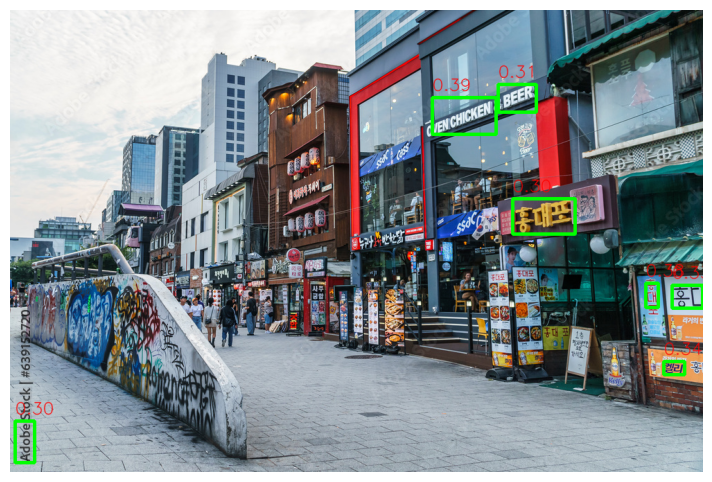

In [12]:
plt.figure(figsize=(10, 6))   # 그림을 그리는 사이즈를 정해준것 (10인치, 6인치)
plt.axis("off")               # 그림의 좌표 표시-off
# plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));  #스레드홀드값은 기본 30%로 그대로 쓰겠다.
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=True));
# conf_labels=True 이면 예측 글자를 보임.

## 배포

### Gradio

In [13]:
import openvino as ov
import cv2
import numpy as np

from pathlib import Path  
import PIL
import gradio as gr

In [14]:
core = ov.Core()
options=core.available_devices
options

['CPU', 'GPU', 'NPU']

## Load Model

In [16]:
model = core.read_model(model="model/horizontal-text-detection-0001.xml")
compiled_model = core.compile_model(model=model, device_name="CPU") 
input_layer = compiled_model.input(0)
output_layer = compiled_model.output("boxes")


In [17]:
def preprocess(image):

    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    N, C, H, W = input_layer.shape
    resized_image = cv2.resize(image, (W, H))
    input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
    return input_image, resized_image 

In [22]:
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],       # 517, 690
        resized_image.shape[:2],   #704, 704
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    
    # rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(bgr_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

## 추론

In [23]:
def predict_image(image):
    input_image, resized_image = preprocess(image)  #이미지 shape 전처리 
    
    boxes = compiled_model([input_image])[output_layer]
    boxes = boxes[~np.all(boxes == 0, axis=1)]
    canvas = convert_result_to_image(image, resized_image, boxes, conf_labels=True)
    
    return canvas

In [24]:
#테스트

image=cv2.imread('data/1111.jpg')
predict_image(image)

array([[[235, 236, 234],
        [236, 237, 235],
        [236, 237, 235],
        ...,
        [ 60,  57,  59],
        [ 72,  71,  67],
        [ 50,  51,  41]],

       [[235, 236, 234],
        [235, 236, 234],
        [235, 236, 234],
        ...,
        [ 70,  66,  65],
        [ 69,  66,  61],
        [ 50,  52,  40]],

       [[235, 236, 234],
        [234, 235, 233],
        [234, 235, 233],
        ...,
        [ 70,  67,  62],
        [ 71,  70,  60],
        [ 54,  54,  40]],

       ...,

       [[195, 189, 176],
        [195, 189, 176],
        [198, 193, 178],
        ...,
        [205, 191, 163],
        [210, 195, 169],
        [203, 187, 164]],

       [[192, 186, 173],
        [192, 186, 173],
        [196, 191, 176],
        ...,
        [193, 179, 151],
        [199, 184, 158],
        [196, 180, 157]],

       [[197, 191, 178],
        [197, 191, 178],
        [200, 195, 180],
        ...,
        [196, 182, 154],
        [195, 180, 154],
        [188, 172, 149]]

In [26]:
demo = gr.Interface(predict_image, gr.Image(), "image")
demo.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
